In [ ]:
# NEXT STEPS:

#1) compare vertex, cga, and published solvent effects phase diagrams (use ImageJ) -> any discrepancy w cga? fix

# conclusions: 
#             - vertex matches solvent effects
#              - cga doesnt match vertex

# NEXT STEP: trye 200 n_b, 1000 snapshot cga, see if get better accuracy. if not, do error analysis

#2) represent square-cylindrical phsae as orderparameter (critical wavevectors) -> find gamma 3, gamma 4 constants

#3) Develop bead mutagenesis code 

### procedure: 
- find q*, 
- represent phases of interest in terms of q*
- evaluate gammas at q*,
- minimize wrt amplitude, 
- compare 

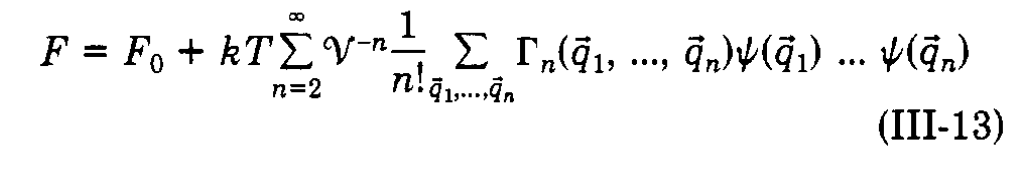

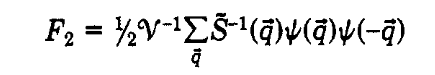

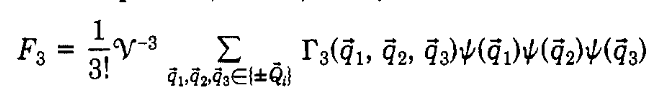

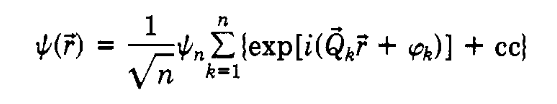

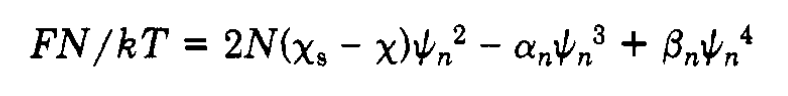

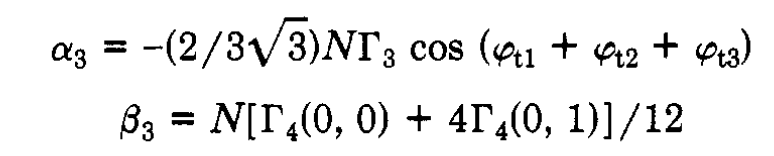

# Vertex (Greens functions)

In [6]:
import sys
sys.path.append("./vertex_subroutines")
from GAMcalc import *  # Code for calculating vertex functions
import propagator  # propagator object used to store pre-calculated values
import wignerD as wd # wigner D object used to store pre-calculated values

In [ ]:
import importlib
from cga import *
#import cga

In [ ]:
#from cga import *
import cga
import GAMcalc
importlib.reload(cga)
importlib.reload(GAMcalc)

In [7]:
pset=propagator.prop_set(nlam=10) 
wigset = wd.wigner_d_vals()

In [8]:
%%time
# 1 hr 2 minutes runtime
N = 100
fa_array = [0.3, 0.4, 0.5]#np.arange(0.2, 0.51, .02)
chi_array = np.arange(5, 30, 0.5)/N #np.array([5, 7, 10, 12, 15, 17, 20])/N #* N
cyl_pnts = np.array([])
lam_pnts = np.array([])
dis_pnts = np.array([])

for FA in fa_array:
    KS = spinodal(pset, N, FA)
    q_star = KS[0]
    #print("q*: ", q_star)
    cyl_q1 = q_star*np.array([1, 0, 0])
    cyl_q2 = 0.5*q_star*np.array([-1, np.sqrt(3), 0])
    cyl_q3 = 0.5*q_star*np.array([-1, -np.sqrt(3), 0])
    cyl_qs = np.array([cyl_q1, cyl_q2, cyl_q3])

    lam_q = q_star*np.array([1, 0, 0])
    lam_g3 = 0
    cyl_g3 = (1/6) * (1/(3*np.sqrt(3))) * 12  * gamma3(pset, N, FA, cyl_qs)
    #print("cyl_g3: ", cyl_g3)
    lam_g4 = (1/24) * (6) * (1/4) * gamma4(pset, wigset, N, FA, np.array([lam_q, -lam_q, lam_q, -lam_q]))
    #print("lam_g4: ", lam_g4)
    #old cyl
    cyl_g4 = (1/12)* (gamma4(pset, wigset, N, FA, np.array([cyl_q1 , -cyl_q1 , cyl_q1 , -cyl_q1 ])) + \
              4*gamma4(pset, wigset, N, FA, np.array([cyl_q1, -cyl_q1, cyl_q2, -cyl_q2])))
    
    #new cyl
    #cyl_g4 = (1/24) * (1/9) * (6 * gamma4(pset, wigset, N, FA, np.array([cyl_q1 , -cyl_q1 , cyl_q1 , -cyl_q1 ])) + \
    #          6 * 4 * gamma4(pset, wigset, N, FA, np.array([cyl_q1, -cyl_q1, cyl_q2, -cyl_q2])))
    #print("cyl_g4: ", cyl_g4)
    for CHI in chi_array:
        lam_g2 = (1/2) * 2 * (1/2) * gamma2(pset, N, FA, q_star, CHI)
        #print("lam_g2: ", lam_g2)
        
        #old cyl_g2
        #cyl_g2 = 0.5 * (1/3) * 3 *  gamma2(pset, N, FA, q_star, CHI)
        #new cyl_g2
        cyl_g2 = (1/2) * 6 * (1/3) * gamma2(pset, N, FA, q_star, CHI) 
        #print("cyl_g2: ", cyl_g2)
        amp_l = optimize.fmin(lambda amp: np.real(amp**2 * lam_g2 + amp**3 * lam_g3 + amp**4 * lam_g4), 1,\
                      disp=False)
        amp_c = optimize.fmin(lambda amp: np.real(amp**2 * cyl_g2 + amp**3 * cyl_g3 + amp**4 * cyl_g4), 1,\
                      disp=False)
        lamF = amp_l**2 * lam_g2 + amp_l**3 * lam_g3 + amp_l**4 * lam_g4
        cylF = amp_c**2 * cyl_g2 + amp_c**3 * cyl_g3 + amp_c**4 * cyl_g4
        
        point = np.array([FA, CHI*N])
        if (lamF > 0 and cylF > 0):
            #disordered stable
            dis_pnts = np.append(dis_pnts, point)
        elif (lamF < cylF):
            lam_pnts = np.append(lam_pnts, point) 
        else:
            cyl_pnts = np.append(cyl_pnts, point)
    print("one FA done!!")
            

./vertex_subroutines\MultiPoint.py:206: RuntimeWarning: invalid value encountered in cdouble_scalars
  if abs(out/(sum2+tol))<tol and l2>max(lam0_2,lam_2):
./vertex_subroutines\MultiPoint.py:209: RuntimeWarning: invalid value encountered in cdouble_scalars
  if abs(sum2/(sum1+tol))<tol and l1>max(lam0_1,lam_1):
./vertex_subroutines\MultiPoint.py:206: RuntimeWarning: invalid value encountered in cdouble_scalars
  if abs(out/(sum2+tol))<tol and l2>max(lam0_2,lam_2):
./vertex_subroutines\MultiPoint.py:209: RuntimeWarning: invalid value encountered in cdouble_scalars
  if abs(sum2/(sum1+tol))<tol and l1>max(lam0_1,lam_1):


one FA done!!
one FA done!!
one FA done!!
Wall time: 5min 55s


In [9]:
%%time

#generate spinodal
#N = 10
f_as = fa_array #= np.arange(0.2, 0.505, .02)#np.arange(0.1, 1, 0.1)
spin_array_vertex = np.zeros(len(f_as))
for i, FA in enumerate(f_as):
    chis = np.arange(8, 24, 0.1)/N #np.arange(0, 40, 0.1) 
    min_G_vals = np.zeros(len(chis))
    for j,CHI in enumerate(chis):
        #evaluate gamma2 at the chi k_spinodal for appropriate length, find when equals zero
        KS = spinodal(pset, N, FA)
        G = gamma2(pset, N, FA, KS, CHI)
        min_G_vals[j] = G # b/c g2 is 1x1 matrix, eigenvalue is the value of g2 itself. 
    spin_array_vertex[i] = chis[np.argmin((abs(min_G_vals)))]

<timed exec>:12: ComplexWarning: Casting complex values to real discards the imaginary part


Wall time: 16.2 s


Text(0.5, 0, '$f_A$')

<Figure size 432x288 with 0 Axes>

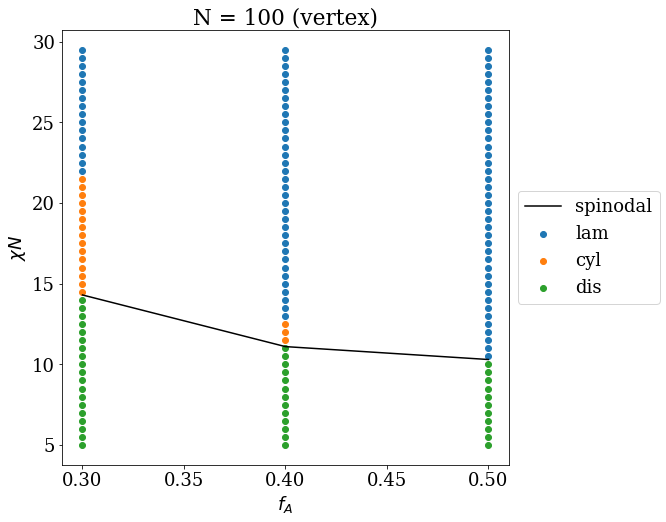

In [11]:
fig = plt.figure()
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
ax = plt.subplot(111)


ax.plot(f_as, spin_array_vertex*N, label="spinodal", color = "black")#, zorder = 0)
ax.scatter(lam_pnts[::2], lam_pnts[1::2], label = "lam")
ax.scatter(cyl_pnts[::2], cyl_pnts[1::2], label = "cyl")
ax.scatter(dis_pnts[::2], dis_pnts[1::2], label = "dis")


box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title("N = 100 (vertex)")
ax.set_ylabel("$\chi N$")
ax.set_xlabel("$f_A$")

# Chain growth algorithm

In [1]:
import importlib
from cga import *

In [ ]:
#from cga import *
import cga
importlib.reload(cga)

In [54]:
%%time

N = 100 #length in kuhn lengths
n_p = 15
n_b = 2000# (n_b >> N) for kappa approx in cga to be accurate
num_snapshots = 100

fa_array = [0.3, 0.4, 0.5]#np.arange(n_b/5, n_b/2+ 0.00001, 10)/n_b#np.arange(0.3, 0.51, .02) ### ONLY CHOOSE FAS which lead to whole bead type ratios
chi_array = np.arange(5, 30, 0.5)/N #np.array([5, 7, 10, 12, 15, 17, 20])*N

cyl_pnts_cga = np.array([])
lam_pnts_cga = np.array([])
dis_pnts_cga = np.array([])


for FA in fa_array:
    
    otpt = wlc_cga_vect(N, n_p, n_b, FA, num_snapshots)
    #otpt_s2_spn = wlc_cga_vect(N, n_p, n_b, FA, num_snapshots=10000)
    
    KS = spin(n_p, n_b, otpt, N, FA)
    #KS = spinodal(pset, N, FA)   #need at least 1000 sps to be accurate
    q_star = KS[0]
#     print("q* cga: ", q_star)
#     print("q* vert: ", spinodal(pset, N, FA)[0])
    
    cyl_q1 = q_star*np.array([1, 0, 0])
    cyl_q2 = 0.5*q_star*np.array([-1, np.sqrt(3), 0])
    cyl_q3 = 0.5*q_star*np.array([-1, -np.sqrt(3), 0])
    cyl_qs = np.array([cyl_q1, cyl_q2, cyl_q3])

    lam_q = q_star*np.array([1, 0, 0])
    lam_g3 = 0
    cyl_g3 = (1/6) * (1/(3*np.sqrt(3))) * 12  * gam3(n_p, n_b, otpt, N, cyl_qs, FA)
    #print("cyl_g3: ", cyl_g3)
    lam_g4 =  (1/24) * (6) * (1/4) * gam4(n_p, n_b, otpt, N, np.array([lam_q, -lam_q, lam_q, -lam_q]), FA)
    #print("lam_g4: ", lam_g4)
    
    #old cyl_g4
    cyl_g4 = (1/12)* (gam4(n_p, n_b, otpt, N, np.array([cyl_q1 , -cyl_q1 , cyl_q1 , -cyl_q1 ]), FA) + \
              4*gam4(n_p, n_b, otpt, N, np.array([cyl_q1, -cyl_q1, cyl_q2, -cyl_q2]), FA))
    #print("cyl_g4: ", cyl_g4)
    #new cyl_g4
    #cyl_g4 = (1/24) * (1/9) * ( 6 * gam4(n_p, n_b, otpt, N, np.array([cyl_q1 , -cyl_q1 , cyl_q1 , -cyl_q1 ]), FA) + \
    #          6 * 4 *gam4(n_p, n_b, otpt, N, np.array([cyl_q1, -cyl_q1,  cyl_q2, -cyl_q2]), FA))
    
    #print("cyl_g4: ", cyl_g4)
    for CHI in chi_array:
        lam_g2 =  (1/2) * 2 * (1/2) * gam2(n_p, n_b, otpt, N, lam_q, CHI, FA)
        #print("lam_g2: ", lam_g2)
        
        #old cyl_g2
        #cyl_g2 = N * 0.5 * (1/(3*np.sqrt(3))) * 3 * gam2(n_p, n_b, otpt, N, cyl_q1, CHI, FA)
        
        #new cyl_g2
        cyl_g2 = (1/2) * 6 * (1/3) * gam2(n_p, n_b, otpt, N, cyl_q1, CHI, FA) #1/3 bc 2 order params, 6 bc delta fucntion math
        #print("cyl_g2: ", cyl_g2)
        amp_l = optimize.fmin(lambda amp: np.real(amp**2 * lam_g2 + amp**3 * lam_g3 + amp**4 * lam_g4), 1,\
                      disp=False)[0]
        amp_c = optimize.fmin(lambda amp: np.real(amp**2 * cyl_g2 + amp**3 * cyl_g3 + amp**4 * cyl_g4), 1,\
                      disp=False)[0]
        lamF = amp_l**2 * lam_g2 + amp_l**3 * lam_g3 + amp_l**4 * lam_g4
        cylF = amp_c**2 * cyl_g2 + amp_c**3 * cyl_g3 + amp_c**4 * cyl_g4
        
        point = np.array([FA, CHI*N])
        if (lamF > 0 and cylF > 0):
            #disordered stable
            dis_pnts_cga = np.append(dis_pnts_cga, point)
        elif (lamF < cylF):
            lam_pnts_cga = np.append(lam_pnts_cga, point) 
        else:
            cyl_pnts_cga = np.append(cyl_pnts_cga, point)
    print("one FA done!!")
            

one FA done!!
one FA done!!
one FA done!!
Wall time: 12min 15s


Text(0.5, 0, '$f_A$')

<Figure size 432x288 with 0 Axes>

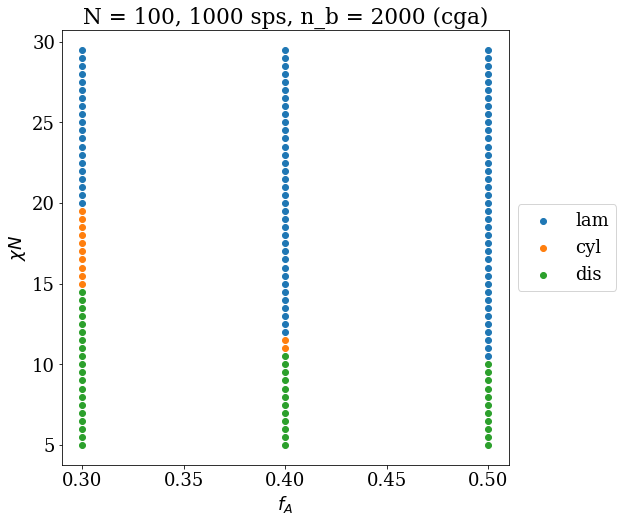

In [55]:
fig = plt.figure()
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
ax = plt.subplot(111)


#ax.plot(f_as, spin_array_vertex*N , label="spinodal", color = "black")#, zorder = 0)
ax.scatter(lam_pnts_cga[::2], lam_pnts_cga[1::2], label = "lam")
ax.scatter(cyl_pnts_cga[::2], cyl_pnts_cga[1::2], label = "cyl")
ax.scatter(dis_pnts_cga[::2], dis_pnts_cga[1::2], label = "dis")


box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title("N = 100, 1000 sps, n_b = 2000 (cga)")
ax.set_ylabel("$\chi N$")
ax.set_xlabel("$f_A$")

#semiflexiblity expands lamellar stability

### Spinodal

In [ ]:
%%time
N = 1
f_as = fa_array = np.arange(0.3, 0.505, .02)#np.arange(0.1, 1, 0.1)
spin_array_vertex_1 = np.zeros(len(f_as))
for i, FA in enumerate(f_as):
    chis = np.arange(5, 10, 0.1) #np.arange(0, 40, 0.1) 
    min_G_vals = np.zeros(len(chis))
    for j,CHI in enumerate(chis):
        #evaluate gamma2 at the chi k_spinodal for appropriate length, find when equals zero
        KS = spinodal(pset, N, FA)
        G = gamma2(pset, N, FA, KS, CHI)
        min_G_vals[j] = G # b/c g2 is 1x1 matrix, eigenvalue is the value of g2 itself. 
    spin_array_vertex_1[i] = chis[np.argmin((abs(min_G_vals)))] 
    
# multiply by N!! this is just chi duhhhh

In [ ]:
%%time
N = 10
f_as = fa_array = np.arange(0.3, 0.505, .02)#np.arange(0.1, 1, 0.1)
spin_array_vertex_10 = np.zeros(len(f_as))
for i, FA in enumerate(f_as):
    chis = np.arange(0, 3, 0.01) #np.arange(0, 40, 0.1) 
    min_G_vals = np.zeros(len(chis))
    for j,CHI in enumerate(chis):
        #evaluate gamma2 at the chi k_spinodal for appropriate length, find when equals zero
        KS = spinodal(pset, N, FA)
        G = gamma2(pset, N, FA, KS, CHI)
        min_G_vals[j] = G # b/c g2 is 1x1 matrix, eigenvalue is the value of g2 itself. 
    spin_array_vertex_10[i] = chis[np.argmin((abs(min_G_vals)))] 
    
# multiply by N!! this is just chi duhhhh

In [ ]:
%%time
N = 100
f_as = fa_array = np.arange(0.3, 0.505, .02)#np.arange(0.1, 1, 0.1)
spin_array_vertex_1000 = np.zeros(len(f_as))
for i, FA in enumerate(f_as):
    chis = np.arange(9, 17, 0.1) #np.arange(0, 40, 0.1) 
    min_G_vals = np.zeros(len(chis))
    for j,CHI in enumerate(chis):
        #evaluate gamma2 at the chi k_spinodal for appropriate length, find when equals zero
        KS = spinodal(pset, N, FA)
        G = gamma2(pset, N, FA, KS, CHI)
        min_G_vals[j] = G # b/c g2 is 1x1 matrix, eigenvalue is the value of g2 itself. 
    spin_array_vertex_100[i] = chis[np.argmin((abs(min_G_vals)))] 
    
# multiply by N!! this is just chi duhhhh

In [ ]:
fig = plt.figure()
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
ax = plt.subplot(111)


ax.plot(f_as, spin_array_vertex_1 * 1, label="N = 1", color = "black")
ax.plot(f_as, spin_array_vertex_10 * 10, label="N = 10", color = "blue")
ax.plot(f_as, spin_array_vertex_100 * 100, label="N = 100", color = "red")

# Unresolved issues

In [ ]:
#UNRESOLVED ISSUES

#1) need to make sf3 match bw cga and vertex. currently cga assumes more sf sub values are equal than vertex

#2) need to ensure that gam4 of different wavevectors are equivalent

#3) increase q_star accuracy? need 1000sps to make sure it has correct trend with FA. may be influenced by n_b

#4) spin function so slow compared to vertex spinodal
gam4(n_p, n_b, otpt, N, np.array([cyl_q1, -cyl_q1, cyl_q1, -cyl_q1]), FA)
gam4(n_p, n_b, otpt, N, np.array([cyl_q2, -cyl_q2, cyl_q2, -cyl_q2]), FA)
gam4(n_p, n_b, otpt, N, np.array([cyl_q3, -cyl_q3, cyl_q3, -cyl_q3]), FA)

gamma4(pset, wigset, N, FA, np.array([cyl_q1 , -cyl_q1 , cyl_q1 , -cyl_q1 ]))
gamma4(pset, wigset, N, FA, np.array([cyl_q2 , -cyl_q2 , cyl_q2 , -cyl_q2 ]))
gamma4(pset, wigset, N, FA, np.array([cyl_q3 , -cyl_q3 , cyl_q3 , -cyl_q3 ]))

# Testing

In [ ]:
import sys
sys.path.append("./vertex_subroutines")
from GAMcalc import *  # Code for calculating vertex functions
import propagator  # propagator object used to store pre-calculated values
import wignerD as wd # wigner D object used to store pre-calculated values

In [ ]:
import importlib
from cga import *
#import cga

In [ ]:
#from cga import *
import cga
import GAMcalc
importlib.reload(cga)
importlib.reload(GAMcalc)

In [ ]:
pset=propagator.prop_set(nlam=10) 
wigset = wd.wigner_d_vals()

In [49]:
n_p = 15
n_b = 2000

In [51]:
#paradox 1: sf3 is LESS accurate for large q, but gam3 is MORE accurate for large q (b/c sf2 inverse? nope)
#mini paradox 2: sf3 vertex gives negative sf3 at FA = 0.3, qstar = 8 , N = 1. DOESNT REALLY MATTER!

#gam 3 basically accurate regardless of FA (off by ~0.1)
#********************gam 3 HIGHLY INaccurate for small q (!!?!?) but at the q we are at, all good*****************
#gam 3 basicall accurate across N (less accurate at higher N)

#********************gam4 HIGHLY INaccurate for small q (!!?!?) and at q=8, still bad***************** partially resolved!!
#********************gam4(q_cyl1) != gam4(q_cyl2)*****************
# num snapshot independent


#s3, s4 have minimal error at qstar =2

### TO DO: 
# - figure out why gam4(q_cyl1) != gam4(q_cyl2); gamma4(q_cyl1, qcyl2) != gam4(q_cyl1, qcyl2) -> issue with q_cyl2 and q_cyl3 !!
# attempt phase diagram calc with old and new constants

#old todo
# - figure out why gam4 (and gam3) inaccurate at low q - due to s2 inv-> NO. so what is it?? did np.real, made it better
# walkthorugh, step by step, at q* = 1, what is gamma3 and gam3 calculating. which part is causing 2 oom difference when
# the input is so similar?

qstars = np.array([0.5, 2, 8])#, 5, 8])
Nsarr = np.array([0.1, 1, 10])
FAS = np.array([0.3, 0.4, 0.5])
gam3errarr = np.zeros(len(qstars))



# #analysis to compare s3 ang gam3 for q star

FA = 0.5 #ONLY CHOOSE FA thta leads to WHOLE bead identities
N = 100
otpt = wlc_cga_vect(N, n_p, n_b, FA, num_snapshots=100)

CHI = 0#1

for i, q_star in enumerate(qstars):
    print("q*: ", q_star)
    cyl_q1 = q_star*np.array([1, 0, 0])
    cyl_q2 = 0.5*q_star*np.array([-1, np.sqrt(3), 0])
    cyl_q3 = 0.5*q_star*np.array([-1, -np.sqrt(3), 0])
    cyl_qs = np.array([cyl_q1, cyl_q2, cyl_q3])
    
    print("cga")
#     gam2(n_p, n_b, otpt, N, cyl_q1, CHI, FA)
    print(gam2(n_p, n_b, otpt, N, cyl_q1, CHI, FA))
    
    print("vertex")
#     gamma2(pset, N, FA, q_star, CHI)
    print(gamma2(pset, N, FA, q_star, CHI))
    
#     print(gam2(n_p, n_b, otpt, N, cyl_q1, CHI, FA) - gamma2(pset, N, FA, q_star, CHI))
    
#     print("cga s2")
#     print(get_sf2_vect(n_p, n_b, otpt, cyl_q1, FA, N))
    
# #     print("cga s2 nonvect")
# #     print(get_sf2(n_p, n_b, otpt, cyl_q1))
#     print("vertex s2")
#     print(s2wlc(pset, N, FA, cyl_q1[0], sequence='all'))
    
#     print("cga s2inv")
#     print(invert_sf2(get_sf2_vect(n_p, n_b, otpt, cyl_q1, FA, N), cyl_q1, N))
#     print("vertex s2 inv")
#     print(s2inverse(pset, N, FA, np.linalg.norm(cyl_q1)))
    
#     print("cga sf3")
#     print(get_sf3_vect(n_p, n_b, otpt, cyl_qs, FA, N))
#     print("vertex sf3")
#     print(s3wlc(pset, N, FA, cyl_qs))

#     cga_gam3 = np.real(gam3(n_p, n_b, otpt, N, cyl_qs, FA))
#     vertex_gam3 = np.real(gamma3(pset, N, FA, cyl_qs))
#     print("cga gam3: ", cga_gam3)
#     print("vertex gam3: ", vertex_gam3)
#     gam3errarr[i] = np.abs(cga_gam3 - vertex_gam3)/(cga_gam3 * vertex_gam3)



#     print("cga")
#     print(gam4(n_p, n_b, otpt, N, np.array([cyl_q2, -cyl_q2, cyl_q2, -cyl_q2]), FA))
    
#     print("cga")
#     print(gam4(n_p, n_b, otpt, N, np.array([cyl_q3, -cyl_q3, cyl_q3, -cyl_q3]), FA))

#     print('vertex s4: ', s4wlc(pset, wigset, N, FA, [cyl_q1 , -cyl_q1 , cyl_q2 , -cyl_q2 ]))
#     print('cga s4: ', get_sf4_vect(n_p, n_b, otpt, [cyl_q1 , -cyl_q1 , cyl_q2 , -cyl_q2 ], N))
    
#     print("vertex g4")
#     vg4 = gamma4(pset, wigset, N, FA, np.array([cyl_q1 , -cyl_q1 , cyl_q1 , -cyl_q1 ]))
#     print(vg4)
#     print("cga g4")
#     cgag4 = gam4(n_p, n_b, otpt, N, np.array([cyl_q1, -cyl_q1, cyl_q1, -cyl_q1]), FA)
#     print(cgag4)
    
#     print("how is gam4 so innacurate w/ accurate inputs?")
          
  
    
    
    
# #analysis to compare gam 3 for dif FA 
# N = 1
# q_star = 8
# cyl_q1 = q_star*np.array([1, 0, 0])
# cyl_q2 = 0.5*q_star*np.array([-1, np.sqrt(3), 0])
# cyl_q3 = 0.5*q_star*np.array([-1, -np.sqrt(3), 0])
# cyl_qs = np.array([cyl_q1, cyl_q2, cyl_q3])

# for i, FA in enumerate(FAS):
#     print("FA: ", FA)
#     otpt = wlc_cga_vect(N, n_p, n_b, FA, num_snapshots=100)

    
#     print("cga")
#     print(get_sf3_vect(n_p, n_b, otpt, cyl_qs, FA, N))
#     print("vertex")
#     print(s3wlc(pset, N, FA, cyl_qs))
#     cga_gam3 = np.real(gam3(n_p, n_b, otpt, N, cyl_qs, FA))
#     vertex_gam3 = np.real(gamma3(pset, N, FA, cyl_qs))
#     print(cga_gam3)
#     print(vertex_gam3)
    
#     print("vertex gam4: ")
#     print(gamma4(pset, wigset, N, FA, np.array([cyl_q1 , -cyl_q1 , cyl_q1 , -cyl_q1 ])))
          
#     print("cga gam4: ")
#     print(gam4(n_p, n_b, otpt, N, np.array([cyl_q1, -cyl_q1, cyl_q1, -cyl_q1]), FA))
#     gam3errarr[i] = np.abs(cga_gam3 - vertex_gam3)/(cga_gam3 * vertex_gam3)    
    
# #analysis to compare gam 3 for dif FA 
# FA = 0.45
# q_star = 2
# cyl_q1 = q_star*np.array([1, 0, 0])
# cyl_q2 = 0.5*q_star*np.array([-1, np.sqrt(3), 0])
# cyl_q3 = 0.5*q_star*np.array([-1, -np.sqrt(3), 0])
# cyl_qs = np.array([cyl_q1, cyl_q2, cyl_q3])

# for i, N in enumerate(Nsarr):
#     print("N: ", N)
#     otpt = wlc_cga_vect(N, n_p, n_b, FA, num_snapshots=1000)

    
#     print("cga")
#     print(get_sf3_vect(n_p, n_b, otpt, cyl_qs, FA, N))
#     print("vertex")
#     print(s3wlc(pset, N, FA, cyl_qs))
#     cga_gam3 = np.real(gam3(n_p, n_b, otpt, N, cyl_qs, FA))
#     vertex_gam3 = np.real(gamma3(pset, N, FA, cyl_qs))
#     print(cga_gam3)
#     print(vertex_gam3)
#     gam3errarr[i] = np.abs(cga_gam3 - vertex_gam3)/(cga_gam3 * vertex_gam3) 
    
####  
#### sf3 need to match corr calc
#### go through gam4 and see why it is inaccurate even with accurate inputs at low Q!! start at G4
#### 

q*:  0.5
cga
(0.2066664348371861+0.006580006226473684j)
vertex
(0.20647501902015197+1.9602996715602753e-17j)
q*:  2.0
cga
(1.2334927430214404+0.02591391660565134j)
vertex
(1.2710764264169767+1.4665957821782753e-16j)
q*:  8.0
cga
(9.91219755182487-0.29415397532871557j)
vertex
(9.8378547903737+1.8208627430037402e-15j)


In [47]:
k0 = 1e-2
kf = 1e2
nk = 50
k_vec = np.logspace(np.log10(k0), np.log10(kf), nk)
sf3_arr = np.zeros(nk)
for i, k in enumerate(k_vec):
    q_star = k
    cyl_q1 = q_star*np.array([1, 0, 0])
    cyl_q2 = 0.5*q_star*np.array([-1, np.sqrt(3), 0])
    cyl_q3 = 0.5*q_star*np.array([-1, -np.sqrt(3), 0])
    cyl_qs = np.array([cyl_q1, cyl_q2, cyl_q3])
    sf3_arr[i] = get_sf2_vect(n_p, n_b, otpt, cyl_q1, FA, N)[0][1]

<ipython-input-47-cfa9e524a77c>:12: ComplexWarning: Casting complex values to real discards the imaginary part
  sf3_arr[i] = get_sf2_vect(n_p, n_b, otpt, cyl_q1, FA, N)[0][1]


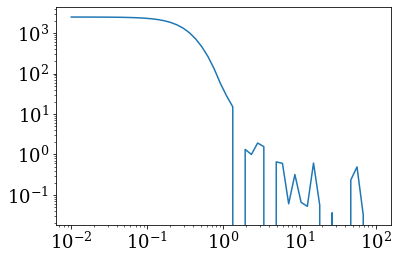

In [48]:
plt.loglog(k_vec, sf3_arr)

In [23]:
%%time
get_sf2_vect(n_p, n_b, otpt, cyl_q1, FA, N)

Wall time: 1.81 s


array([[1461.01037337+0.j        ,  504.83067347+2.03478449j],
       [ 504.83067347+2.03478449j, 1475.48334215+0.j        ]])

In [24]:
%%time
s2wlc(pset, N, FA, cyl_q1[0], sequence='all')

Wall time: 116 ms


array([[1442.90423043+2.01357973e-15j,  472.4840219 +1.15725209e-13j],
       [ 472.4840219 +1.15725209e-13j, 1442.90423043+2.01357973e-15j]])